In [1]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [2]:
import numpy as np 
import pandas as pd
#import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import glob 
%load_ext tensorboard
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import normalize
import os
from PIL import Image
from keras.optimizers import Adam

2023-09-22 08:56:12.362754: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = '/workspace/copytodgx/node_image_2x'
data = glob.glob(path + "/*")
data[:4] 

['/workspace/copytodgx/node_image_2x/CAIB-T00000434OC01R01R1307HE_2.tiff',
 '/workspace/copytodgx/node_image_2x/CAIB-T00000472OC01R01R0406HE.tiff',
 '/workspace/copytodgx/node_image_2x/CAIB-T00000152OC02R01R3415HE.tiff',
 '/workspace/copytodgx/node_image_2x/CAIB-T00000058OC02R02R0924HE.tiff']

In [4]:
image_id = []
for i in data[:]:
  name = i.split('/')[-1].split('.')[0]
  image_id.append(name)

In [5]:
len(image_id)

237

In [6]:
df = pd.DataFrame(image_id, columns=['id'])

In [7]:
df

,id
0,CAIB-T00000434OC01R01R1307HE_2
1,CAIB-T00000472OC01R01R0406HE
2,CAIB-T00000152OC02R01R3415HE
3,CAIB-T00000058OC02R02R0924HE
4,CAIB-T00000414OC01R01P0101HE
...,...
232,CAIB-T00000422OC01R02R0706HE
233,CAIB-T00000039OC01R01R0301HE
234,CAIB-T00000189OC03R03R0818HE
235,CAIB-T00000454OC01R01R1408HE_2


In [8]:
idx = np.random.rand(len(df)) < 0.7
test_df = df[~idx]
train_df = df[idx]
test_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

In [9]:
train_df.shape, test_df.shape

((161, 2), (76, 2))


#colormap in matplotlib
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [10]:

def display_segmentation_data(img_num, df):

    #Create a pyplot with two images
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (12, 8))

    target_size = (1000,1000)

    #Read Seismic image and corresponding mask
    original_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/node_image_2x/' + df.loc[img_num, 'id'] + '.tiff', color_mode='rgb',target_size=(1000, 1000))
    seismic_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/node_image_2x/' + df.loc[img_num, 'id'] + '.tiff', color_mode='grayscale',target_size=(1000, 1000))
    #seismic_img = tf.keras.preprocessing.image.smart_resize(seismic_img,target_size)

    mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_masks_2x/' + df.loc[img_num, 'id'] + '.png', color_mode='grayscale',target_size=(1000, 1000))
    #mask_img = tf.keras.preprocessing.image.smart_resize(mask_img,target_size)
    
    #Show both images
    ax1.set_title('Original_image')
    ax1.imshow(original_img,interpolation = 'bilinear')
    ax2.set_title('Preprocessed_image_for_input_grayscale')
    ax2.imshow(seismic_img,cmap='RdBu_r',interpolation = 'bilinear')
    ax3.set_title(f'Mask_node_uniq_classes:{np.unique(mask_img)}')
    ax3.imshow(mask_img, cmap='gray', vmin=0, vmax=1, interpolation='bilinear')

   
    plt.show()

In [ ]:
img_num = np.random.randint(0, train_df.shape[0])

display_segmentation_data(img_num, train_df)

In [31]:
img_size = 1000
num_classes = 2

In [32]:
def batch_generator(df, batch_size=16):

    while True:

        #Create random indexes
        idx = np.random.randint(0, df.shape[0], batch_size)

        #Initialize numpy arrays for X and y
        #Input image is size img_size,img_size,1
        X = np.zeros((batch_size, img_size, img_size,1))
        #Mask's size is img_size, img_size, 1
        y = np.zeros((batch_size, img_size, img_size,num_classes))

        #Populate X and y with actual data
        for i in range(len(idx)):

            #Read image
            img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/node_image_2x/' + df.loc[idx[i],'id'] + '.tiff', color_mode='grayscale',
                                                        target_size=(img_size, img_size))
            img = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')/255.0

            X[i] = img

            #Read mask
            mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_masks_2x/' + df.loc[idx[i],'id'] + '.png',
                                                            color_mode = 'grayscale',
                                                            target_size=(img_size, img_size))
            mask_img = tf.keras.preprocessing.image.img_to_array(mask_img).astype('uint8')/255.0
            #One hot encoding
            mask_img = tf.keras.utils.to_categorical(mask_img, num_classes=num_classes)

            y[i] = mask_img

        yield X, y

In [33]:
a = batch_generator(df, batch_size= 16)

In [34]:
a

<generator object batch_generator at 0x7f8f91d6a180>

In [35]:
x, y = next(a)

In [36]:
print(x.shape)
print(y.shape)

(16, 1000, 1000, 1)
(16, 1000, 1000, 2)


In [37]:
y[:1]

array([[[[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        ...,

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]]]])

In [38]:
np.unique(y[0])

array([0., 1.])

In [39]:
def conv2d_block(input_tensor, n_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [40]:
def build_unet(input_img, n_filters=16, dropout=0.1):

    #ENCODER - DOWNSAMPLE the image - 1000x1000x1

    #First Block
    c1 = conv2d_block(input_img, n_filters*1) #512x512x16
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) #256x256x16
    p1 = tf.keras.layers.Dropout(dropout)(p1) #256x256x16
    #output will be #256x256x16

    #Second Block
    c2 = conv2d_block(p1, n_filters*2) ##256x256x32
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) #128x128x32
    p2 = tf.keras.layers.Dropout(dropout)(p2)
    #output will be 128x128x32

    #Third Block
    c3 = conv2d_block(p2, n_filters*4) #128x128x64
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3) #64X64X64
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    #output will be 1#64x64x64

   

    #We now have output of Encoder

    #DECODER - UPSAMPLE the feature to generate mask

    #First Block - connected to third block on DOWNSAMPLE side
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), 
                                         strides = (2, 2), 
                                         padding = 'same')(p3) #64x64x128
    #Skip connection
    u6 = tf.keras.layers.concatenate([u6, c3]) #64x64x256
    u6 = tf.keras.layers.Dropout(dropout)(u6) 
    c6 = conv2d_block(u6, n_filters * 8) #64x64x128

    #Second Block - connected to second block on DOWNSAMPLE side
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c6) #128x128x64
    u7 = tf.keras.layers.concatenate([u7, c2])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4)

    #Third Block - connected to first block on DOWNSAMPLE side
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c7) #256x256x32
    u8 = tf.keras.layers.concatenate([u8, c1])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2) 

  

    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c8) #512x512x2

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [41]:
from keras import backend as K
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return K.mean(numerator / (denominator + tf.keras.backend.epsilon()))

In [42]:
from tensorflow.keras.losses import binary_crossentropy
import math

def loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)
    eps = tf.keras.backend.epsilon()
    dice_log = tf.math.log(dice + eps)
    return bce - dice_log

In [43]:
#Clear out notebook session
tf.keras.backend.clear_session()

#Define input layer
input_img = tf.keras.layers.Input((img_size, img_size, 1), name='input_img')

#Build model
model = build_unet(input_img, dropout=.3)

#Compile model
with tf.keras.utils.custom_object_scope({'dice_coefficient': dice_coefficient}):
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy', dice_coefficient])

2023-09-15 10:18:03.030942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78830 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:cb:00.0, compute capability: 8.0


In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 1000, 1000,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1000, 1000,   160         ['input_img[0][0]']              
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1000, 1000,   64         ['conv2d[0][0]']                 
 alization)                     16)                                                           

In [45]:
train_generator = batch_generator(train_df,batch_size=16)
test_generator = batch_generator(test_df, batch_size=16)

In [46]:
train_generator

<generator object batch_generator at 0x7f8f8dd48d60>

In [47]:
test_generator

<generator object batch_generator at 0x7f8f8dd490e0>

In [48]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('mask_seg_old.h5', save_best_only=True, monitor='val_accuracy', verbose=1)

In [49]:
gpu = tf.config.list_physical_devices('GPU')

In [50]:
gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [53]:
model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//2, 
          validation_data=test_generator, 
          validation_steps=test_df.shape[0]//2, 
          callbacks=[model_checkpoint],
          epochs=30)

Epoch 1/30


2023-09-15 13:22:02.169544: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


76/76 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.9226 - dice_coefficient: 0.9153

2023-09-15 13:23:48.526780: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy did not improve from 0.91695
76/76 [==============================] - 164s 2s/step - loss: 0.2585 - accuracy: 0.9226 - dice_coefficient: 0.9153 - val_loss: 0.3295 - val_accuracy: 0.9042 - val_dice_coefficient: 0.9009
Epoch 2/30
76/76 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9248 - dice_coefficient: 0.9184
Epoch 2: val_accuracy improved from 0.91695 to 0.91772, saving model to mask_seg_old.h5
76/76 [==============================] - 166s 2s/step - loss: 0.2533 - accuracy: 0.9248 - dice_coefficient: 0.9184 - val_loss: 0.3032 - val_accuracy: 0.9177 - val_dice_coefficient: 0.9128
Epoch 3/30
76/76 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.9186 - dice_coefficient: 0.9117
Epoch 3: val_accuracy did not improve from 0.91772
76/76 [==============================] - 164s 2s/step - loss: 0.2719 - accuracy: 0.9186 - dice_coefficient: 0.9117 - val_loss: 0.3823 - val_accuracy: 0.8791 - val_dice_coefficient: 0.8727
Epo

In [1]:
pwd

'/workspace/copytodgx'

In [2]:
#random images from test data

def display_model_prediction(img_num, df):
    
    img_size = 1024

    #Read Seismic image and corresponding mask
    rgb_img =tf.keras.preprocessing.image.load_img('/workspace/copytodgx/node_image_2x/' + df.loc[img_num, 'id'] + '.tiff', color_mode='rgb')
    he_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/node_image_2x/' + df.loc[img_num, 'id'] + '.tiff', color_mode='grayscale')
    mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_masks_2x/' + df.loc[img_num, 'id'] + '.png', color_mode='grayscale')

    #Model prediction
    test_img = he_img.resize((img_size, img_size))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
    test_img = np.expand_dims(test_img, axis=0) #1,1000,1000,1

    pred = model.predict(test_img) #1,1000,1000,num_classes
    
    
    predicted_classes = np.argmax(pred[0], axis=-1)
    
    #Create a pyplot with two images
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize = (12, 8))

    #Show both images
    ax1.set_title('RGB image')
    ax1.imshow(rgb_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Pre_processed_image')
    ax2.imshow(he_img.resize((img_size, img_size)), cmap = 'RdBu_r', interpolation = 'bilinear')
    ax3.set_title('Masked_image')
    ax3.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax4.set_title('Predicted image')
    ax4.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


    plt.show()

In [3]:
model = tf.keras.models.load_model('/workspace/copytodgx/mask_seg_old.h5', custom_objects={'loss': loss, 'dice_coefficient': dice_coefficient})


NameError: name 'tf' is not defined

In [82]:
pwd

'/workspace/copytodgx'

1/1 [==============================] - 1s 753ms/step


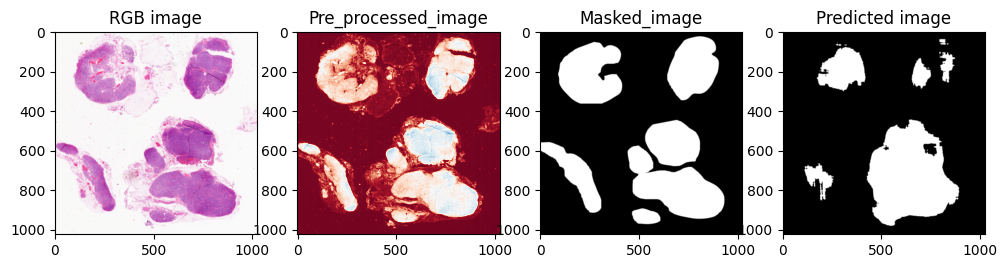

In [83]:
img_num = np.random.randint(0, test_df.shape[0])
display_model_prediction(img_num, test_df)

1/1 [==============================] - 0s 26ms/step


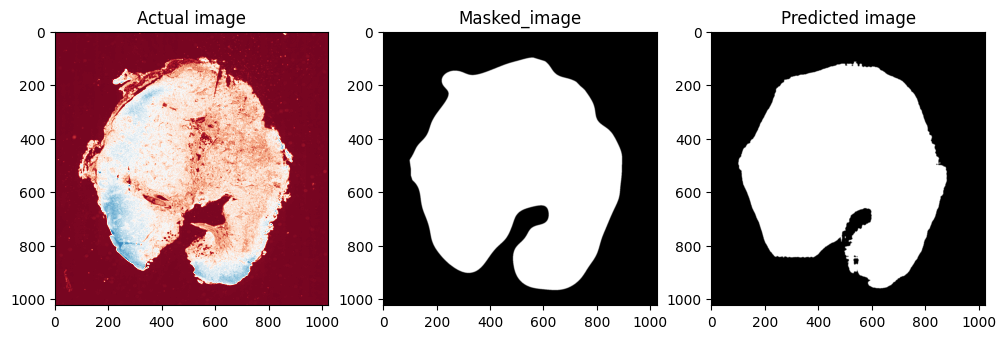

In [85]:
#random image from train and test data
img_size = 1024

    #Read Seismic image and corresponding mask
he_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/node_image_2x/CAIB-T00000061OC02R02S1925HE_2.tiff', color_mode='grayscale')
mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_masks_2x/CAIB-T00000061OC02R02S1925HE_2.png', color_mode='grayscale')

    #Model prediction
test_img = he_img.resize((img_size, img_size))
test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
test_img = np.expand_dims(test_img, axis=0) #1,1000,1000,1

pred = model.predict(test_img) #1,1000,1000,num_classes
    
predicted_classes = np.argmax(pred[0], axis=-1)
    
    #Create a pyplot with two images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))

    #Show both images
ax1.set_title('Actual image')
ax1.imshow(he_img.resize((img_size, img_size)), cmap = 'RdBu_r', interpolation = 'bilinear')
ax2.set_title('Masked_image')
ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
ax3.set_title('Predicted image')
ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


plt.show()

1/1 [==============================] - 0s 27ms/step


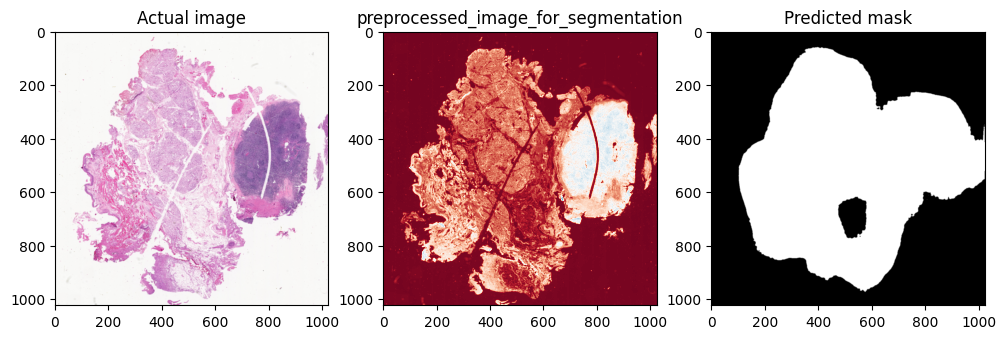

In [86]:
#never seen image before


img_size = 1024

    #Read Seismic image and corresponding mask
he_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/image_for_inference/CAIB-T00002006OC01R01R0404HE.tiff', color_mode='rgb')
mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/image_for_inference/CAIB-T00002006OC01R01R0404HE.tiff', color_mode='grayscale')

    #Model prediction
test_img = mask_img.resize((img_size, img_size))
test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
test_img = np.expand_dims(test_img, axis=0) #1,1000,1000,1

pred = model.predict(test_img) #1,1000,1000,num_classes
    
predicted_classes = np.argmax(pred[0], axis=-1)
    
    #Create a pyplot with two images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))

    #Show both images
ax1.set_title('Actual image')
ax1.imshow(he_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('preprocessed_image_for_segmentation')
ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'RdBu_r', interpolation = 'bilinear')
ax3.set_title('Predicted mask')
ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


plt.show()